# Convex Optimization Exercise 3_10

Dr. Amirmazlaghani

By Gholamreza Dar 400131018

Spring 2022

## Imports

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style('dark')

import cvxpy as cvx

## Hilbert and Tridiag Matrices

In [50]:
def tridiag(a=-1, b=4, c=-1, n=5):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j-1:
                A[i, j] = a
            if i == j:
                A[i, j] = b
            if i == j+1:
                A[i, j] = c
    return A+0.000001


In [51]:
def hilbert(n=5):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i][j] = 1/(i+j+1)
    return A+0.000001


In [52]:
# np.linalg.norm(hilbert(n=40)-(hilbert(n=40)+0.000001))

In [53]:
tridiag()

array([[ 4.000001e+00, -9.999990e-01,  1.000000e-06,  1.000000e-06,
         1.000000e-06],
       [-9.999990e-01,  4.000001e+00, -9.999990e-01,  1.000000e-06,
         1.000000e-06],
       [ 1.000000e-06, -9.999990e-01,  4.000001e+00, -9.999990e-01,
         1.000000e-06],
       [ 1.000000e-06,  1.000000e-06, -9.999990e-01,  4.000001e+00,
        -9.999990e-01],
       [ 1.000000e-06,  1.000000e-06,  1.000000e-06, -9.999990e-01,
         4.000001e+00]])

In [54]:
hilbert()

array([[1.000001  , 0.500001  , 0.33333433, 0.250001  , 0.200001  ],
       [0.500001  , 0.33333433, 0.250001  , 0.200001  , 0.16666767],
       [0.33333433, 0.250001  , 0.200001  , 0.16666767, 0.14285814],
       [0.250001  , 0.200001  , 0.16666767, 0.14285814, 0.125001  ],
       [0.200001  , 0.16666767, 0.14285814, 0.125001  , 0.11111211]])

## Functions

In [55]:
# 1/2 * X^T * A * X - b^T * X
def f(x, A, b):
    return 0.5 * x.T @ A @ x - b.T @ x

In [56]:
def f_prim(x, A, b):
    return A@x-b

def f_prim_norm(x, A, b):
    return np.linalg.norm(f_prim(x, A, b))

In [57]:
def backtracking_algorithm(x, A, b, pk, rho, alpha_0, c):
    alpha = alpha_0
    # Check sufficient decrease condition
    while f(x+alpha*pk, A, b) > f(x, A, b) + c * alpha * f_prim(x, A, b).T @ pk:
        alpha *= rho
    return alpha


#### Steepest Descent

In [58]:
def steepest_descent(x0, A, b, rho, alpha_0, c, max_iter=100):
    x = x0
    for _ in range(max_iter):
        grad = f_prim(x, A, b)
        pk = -grad
        alpha = backtracking_algorithm(x, A, b, pk, rho, alpha_0, c)
        x += alpha * pk
    return x

#### Newton's method

In [59]:
def newtons_method(x0, A, b, rho, alpha_0, c, max_iter=100):
    x = x0
    for _ in range(max_iter):
        grad = f_prim(x, A, b)
        hess = A
        pk = -(np.linalg.inv(hess)@grad)
        
        alpha = backtracking_algorithm(x, A, b, pk, rho, alpha_0, c)
        # Update the current iterate
        x += alpha * pk
    return x

#### BFGS

In [60]:
def approximate_hessian(x0, x_prev, bk, A, b):
    sk = (x0 - x_prev).reshape(-1, 1)
    yk = (f_prim(x0, A, b) - f_prim(x_prev, A, b)).reshape(-1, 1)

    # bk_new = bk + (a/b) - (c/d)
    a = (yk @ yk.T)
    b = (yk.T @ sk).flatten()[0]
    c = (bk @ sk @ sk.T @ bk.T)
    d = (sk.T @ bk @ sk).flatten()[0]

    bk_new = bk + (a/(b+0.0001)) - (c/(d+0.0001))

    return bk_new

In [61]:
def BFGS(x0, A, b, rho, alpha_0, c, max_iter=100):
    x = x0
    # Initialize Hessian approx to I_n
    x_prev = x
    hess_approx = np.eye(A.shape[0])
    for _ in range(max_iter):
        grad = f_prim(x, A, b)
        # Calculate the BFGS pk = -(hess_approx @ grad)
        pk = -(np.linalg.inv(hess_approx)@grad)
        # Calculate the step size
        alpha = backtracking_algorithm(x, A, b, pk, rho, alpha_0, c)
        # Update the Hessian approximation
        hess_approx = approximate_hessian(x0, x_prev, hess_approx, A, b)
        # Update the current iterate
        x_prev = x.copy()
        x += alpha * pk
    return x

## Main

### A)

#### Tridiag

##### n=40

###### Steepest Descent

||Ax* - b|| = 2.2502512834319497e-07


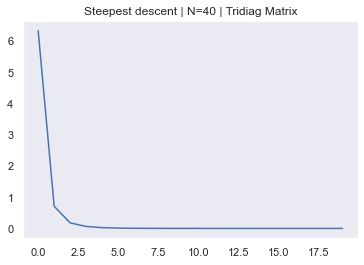

Losses:
6.324555320336759
0.7071350762053884
0.176790493402072
0.06250719370887119
0.024709033329732698
0.010336897808697823
0.004476164487503393
0.001983916109331727
0.000894169202976523
0.0004081441685185846
0.0001881513651028393
8.74292922727793e-05
4.0892620436254504e-05
1.9231181559468885e-05
9.086164107131537e-06
4.3100796309537596e-06
2.051599644969648e-06
9.795287062745565e-07
4.6892772436924073e-07
2.2502512834319497e-07


In [62]:
N = 40
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = steepest_descent(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Steepest descent | N=40 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### Newton's Method

||Ax* - b|| = 0.0


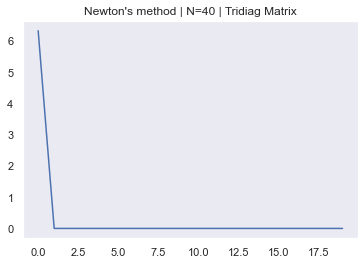

Losses:
6.324555320336759
1.9484335006297032e-15
6.473657049138938e-16
3.510833468576701e-16
1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [63]:
N = 40
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = newtons_method(np.zeros(N), A1, b, rho=0.8, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Newton's method | N=40 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### BFGS

||Ax* - b|| = 2.3423025756762787e-05


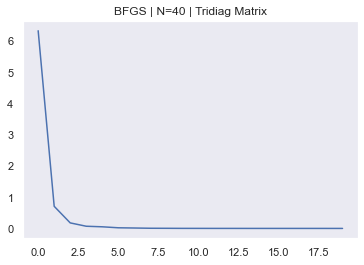

Losses:
6.324555320336759
0.7071350762053884
0.176790493402072
0.06970016185970732
0.051855401279713886
0.020312524738973773
0.013056107491802731
0.005240154400764359
0.003664190994512936
0.0016374211229481935
0.0012681944793565452
0.0005997537627113348
0.0005668947396351264
0.000261606893734078
0.00015552842969069984
0.00014498946449645195
7.316063590809422e-05
4.4085167439401356e-05
2.9814190487329438e-05
2.3423025756762787e-05


In [64]:
N = 40
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = BFGS(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("BFGS | N=40 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

##### n=400

###### Steepest Descent


||Ax* - b|| = 6.496174039399727e-07


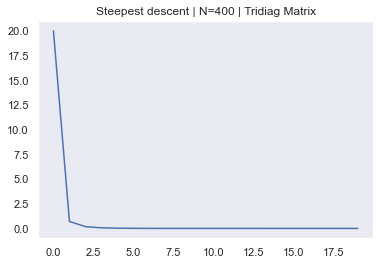

Losses:
20.0
0.7074008764484313
0.1769288797318316
0.06258248473106792
0.02474950374400273
0.010358408827672078
0.004487500893323774
0.001989851665229411
0.0008972612037911581
0.00040974834553599444
0.00018898087711481903
8.785704532728473e-05
4.1112684648206444e-05
1.934417090335218e-05
9.144076736691888e-06
4.3397177795950215e-06
2.066747369673987e-06
9.872613369520805e-07
1.3554568441125577e-06
6.496174039399727e-07


In [65]:
N = 400
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = steepest_descent(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Steepest descent | N=400 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### Newton's Method


||Ax* - b|| = 7.004521915144336e-14


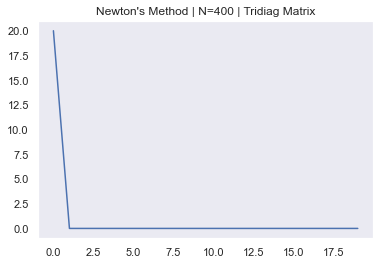

Losses:
20.0
1.600995494923937e-13
8.006709546397179e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14
7.004521915144336e-14


In [66]:
N = 400
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = newtons_method(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Newton's Method | N=400 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### BFGS


||Ax* - b|| = 2.3668890540744887e-05


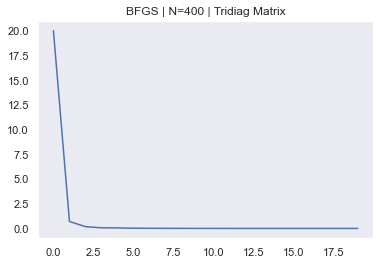

Losses:
20.0
0.7074008764484313
0.1769288797318316
0.0635493317511867
0.05046081909512533
0.018433811744784288
0.013657325234595532
0.005387769807537259
0.003917844739801051
0.0016786053794839654
0.0013188872663189182
0.0005995469317216177
0.0005821162541133462
0.00026285067409195296
0.00015440178745629074
0.000147038466095245
7.361212408108555e-05
4.408306960469583e-05
2.9774689569173663e-05
2.3668890540744887e-05


In [67]:
N = 400
A1 = tridiag(-1, 4, -1, N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = BFGS(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("BFGS | N=400 | Tridiag Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

#### Hilbert

##### n=40

###### Steepest Descent


||Ax* - b|| = 0.2640639548552699


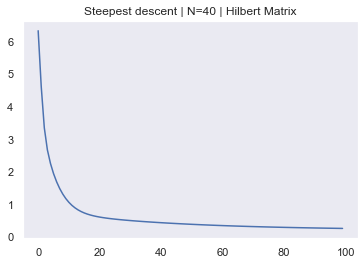

Losses:
6.324555320336759
4.609390419804039
3.346851632945196
2.671346771662709
2.2562539403953945
1.9447345528068611
1.693557376175786
1.4872423126123326
1.3173410869332418
1.177677602186789
1.063187754729913
0.969572569798758
0.8931522775225238
0.8307827003184347
0.7797967996894604
0.7379568010581148
0.7034093470129923
0.6746402987419523
0.6504288253604282
0.6298021623911043


In [68]:
N = 40
A1 = hilbert(n=N)
losses = []

for i in range(100):
    b = np.ones(N)
    x_star = steepest_descent(np.zeros(N), A1, b, rho=0.2, alpha_0=.90, c=0.3, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Steepest descent | N=40 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### Newton's Method


||Ax* - b|| = 5.10845827089928


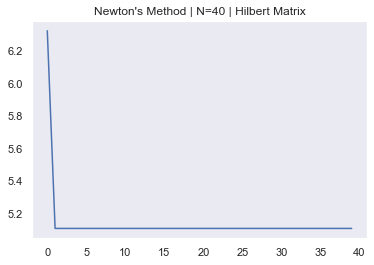

Losses:
6.324555320336759
5.108458270758938
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928
5.10845827089928


In [69]:
N = 40
A1 = hilbert(n=N)
losses = []

for i in range(40):
    b = np.ones(N)
    x_star = newtons_method(np.zeros(N), A1, b, rho=0.01, alpha_0=.69, c=0.2, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Newton's Method | N=40 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### BFGS


||Ax* - b|| = 0.10406200291414314


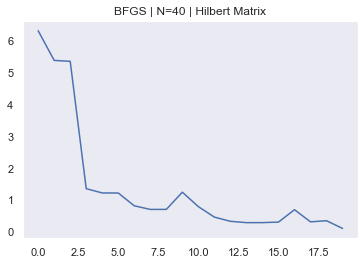

Losses:
6.324555320336759
5.39073850254818
5.362585964732495
1.3550307983475591
1.2197954846825592
1.2184603778240921
0.8157073605957307
0.7020925150636277
0.702977901518234
1.2436178545300796
0.7902124723824214
0.45934756302646323
0.32811371337137496
0.285469060032442
0.28641820435391097
0.302568247690984
0.6929447186549013
0.3110803513081177
0.34614819306681016
0.10406200291414314


In [70]:
N = 40
A1 = hilbert(n=N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = BFGS(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("BFGS | N=40 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

##### n=400

###### Steepest Descent


||Ax* - b|| = 0.49909692277372425


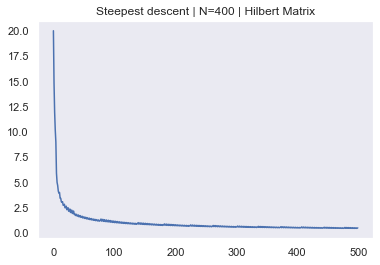

Losses:
20.0
14.823535592868819
11.95994222323626
10.197078715763062
8.997097109278808
5.913006263136445
5.001570883286834
4.6892021119779335
4.1400266622587925
3.9379545959307873
3.999736647355276
3.4352995322821713
3.421533013117999
3.08015845150532
3.021295648227786
3.083063429828538
2.7361319452216435
2.7303936223258134
2.8351586691424076
2.4851009150187764


In [71]:
N = 400
A1 = hilbert(n=N)
losses = []

for i in range(500):
    b = np.ones(N)
    x_star = steepest_descent(np.zeros(N), A1, b, rho=0.2, alpha_0=1, c=0.7, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Steepest descent | N=400 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### Newton's Method


||Ax* - b|| = 19.806990249784967


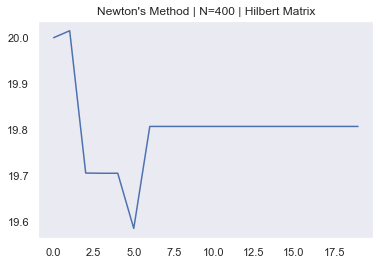

Losses:
20.0
20.015087954802365
19.705618019246387
19.705160714210614
19.70515679382924
19.585208980860507
19.80699082191531
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967
19.806990249784967


In [72]:
N = 400
A1 = hilbert(n=N)
losses = []

for i in range(20):
    b = np.ones(N)
    x_star = newtons_method(np.zeros(N), A1, b, rho=0.09, alpha_0=0.0001, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("Newton's Method | N=400 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];

###### BFGS


||Ax* - b|| = 2.9463282324205635


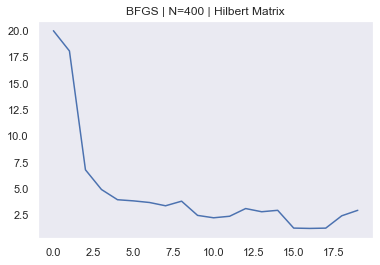

Losses:
20.0
18.079121726674536
6.790868781807805
4.920431291077218
3.9514428570165423
3.8411387192243165
3.6872066770688097
3.3757047675698
3.8119600713775146
2.462278872733405
2.234828651006973
2.380941754624958
3.1126155850648503
2.8084903828554455
2.945331453144843
1.2560975544611401
1.225581008559715
1.2526289547147054
2.425011036192145
2.9463282324205635


In [73]:
N = 400
A1 = hilbert(n=N)
losses = []
for i in range(20):
    b = np.ones(N)
    x_star = BFGS(np.zeros(N), A1, b, rho=0.5, alpha_0=1.0, c=0.1, max_iter=i)
    f_prim_norm_x_star = f_prim_norm(x_star, A1, b)
    losses.append(f_prim_norm_x_star)

print("||Ax* - b|| =", f_prim_norm_x_star)
plt.plot(losses)
plt.title("BFGS | N=400 | Hilbert Matrix")
plt.show()
print("Losses:")
[print(losses[i]) for i in range(20)];